In [1]:
run prep_ana.py

loading data frame named df.
finished loading data frame
unc_mc_process and scales are dictionaries
scale_data = (5.27/19.7)


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%matplotlib inline

In [54]:
#training_df = df[ (df.WW == 1) | (df.DY == 1) | (df.TT == 1)].sample(frac=.33)
training_df = pd.concat( [df[df.WW ==1].sample(n=50000), df[df.DY == 1].sample(n=70000), df[df.TT == 1].sample(n=33000) ] )
test_df = df.drop( training_df.index )
print df.shape
test_df.shape

(5680272, 48)


(5527272, 48)

In [45]:
testing_scales = {"WW": float(df[df.WW == 1].shape[0]) / (df[df.WW == 1].shape[0] - training_df[ training_df.WW == 1 ].shape[0]) ,\
          "DY":  float(df[df.DY == 1].shape[0]) / (df[df.DY == 1].shape[0] - training_df[ training_df.DY == 1 ].shape[0]) ,\
          "TT": float(df[df.TT == 1].shape[0]) / (df[df.TT == 1].shape[0] - training_df[ training_df.TT == 1 ].shape[0]) ,\
          "ZZ": 1,\
          "WZ": 1, "WJ": 1 }

s = {}
for key in scales.keys():
    s[key] = scales[key] * testing_scales[key]

In [69]:
labels = np.empty( training_df.shape[0] )
labels[(training_df.WW == 1).as_matrix()] = 1
labels[(training_df.DY == 1).as_matrix()] = 2
labels[(training_df.TT == 1).as_matrix()] = 2

In [56]:
weights = np.empty(training_df.shape[0] )
weights[(training_df.WW == 1).as_matrix()] = 1.
weights[(training_df.DY == 1).as_matrix()] = 1.#.05
weights[(training_df.TT == 1).as_matrix()] = 1.#.05

In [51]:
features = ['nBJet', 'numb_jets', 'lep1_pt', 'lep2_pt', 'METProj', 'qT', 'mll', 'metMod', 'dPhiLLMET', 'HT', 'lep_Type', 'numbExtraLep', 'metDIVET'] +\
            ['jetPt'+str(i) for i in range(1,3)]
#features = ['nBJet', 'numb_jets', 'lep1_pt', 'lep2_pt', 'METProj', 'qT', 'mll', 'metMod', 'dPhiLLMET', 'HT', 'lep_Type', 'numbExtraLep', 'mllMET'] +\
#            ['jetPt'+str(i) for i in range(1,7)]

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')

In [70]:
clf = clf.fit( np.float32(training_df[features].values) , np.float32(labels), sample_weight=weights)

In [71]:
print clf.score(np.float32(training_df[features].values), np.float32(labels), weights)

0.962026143791


In [72]:
pred = clf.predict_proba(np.float32(test_df[features].values))

In [73]:
test_df["pred_WW"] = pred[:,0]
test_df["pred_DY"] = pred[:,1]
test_df["pred_TT"] = pred[:,1]

In [76]:
cut = .97092
feature_cuts =  (test_df.pred_WW > cut) & (test_df.numbExtraLep == 0) #& (test_df.qT > 0) & ()
feature_cuts_diff = feature_cuts & (test_df.lep_Type > 0) 
feature_cuts_same = feature_cuts & (test_df.lep_Type < 0) 
for process in scales.keys():
    if process in test_df.keys():
        print process, test_df[ (test_df[process] == 1) & feature_cuts_diff].shape[0] * s[process],\
        test_df[ (test_df[process] == 1) & feature_cuts_same].shape[0] * s[process]

TT 268.00743179 117.109630404
WW 3254.53627069 1312.9568178
ZZ 12.0840962997 44.9578434818
DY 719.398984212 995.206901481
WZ 158.001089209 100.45824461


In [15]:
pred_oh_god = clf.predict_proba(np.float32(df[features].values))
df["pred_WW"] = pred_oh_god[:,0]
df["pred_DY"] = pred_oh_god[:,1]
df["pred_TT"] = pred_oh_god[:,2]

In [29]:
#cut = .96992
feature_cuts =  (df.pred_WW > cut) & (df.numbExtraLep == 0) #& (test_df.qT > 0) & ()
feature_cuts_diff = feature_cuts & (df.lep_Type > 0) 
feature_cuts_same = feature_cuts & (df.lep_Type < 0) 
for process in scales.keys():
    if process in df.keys():
        print process, df[ (df[process] == 1) & feature_cuts_diff].shape[0] * scales[process],\
        df[ (df[process] == 1) & feature_cuts_same].shape[0] * scales[process]

TT 307.937933608 117.931015863
WW 3651.43633509 1392.08400118
ZZ 13.2460286362 102.303673259
DY 771.580918269 996.531623303
WZ 171.157560113 133.405997783


# seperate rand .33
TT 312.52600363 139.570494957

WW 3603.62260426 1476.99380174

ZZ 13.4069115751 133.050190471

DY 890.092215518 1236.05258608

WZ 170.406643478 160.202406467


# together rand .33

TT 293.972967078 136.398120856

WW 3833.68333225 1553.68175232

ZZ 13.4069115751 133.050190471

DY 812.072045175 1165.24465208

WZ 170.406643478 160.202406467

# Seperate not-rand

TT 313.753381166 120.130990782

WW 3447.92578084 1345.82876544

ZZ 13.2460286362 102.303673259

DY 788.350963529 1015.89249528

WZ 171.157560113 133.405997783

# NEW
Process:    | WW | DY | TT | ZZ+WZ
---         |--- | ---|--- |---
same flavor |1345|788 |313 | 235 
diff flavor |3447|1015|120 | 184 

# OLD
Process:    | WW | DY | TT | ZZ+WZ
---         |---| ---|--- |---
same flavor |1057|182|36 | 101 
diff flavor |4426|485|178 | 279 

# together not rand

TT 307.937933608 117.931015863

WW 3651.43633509 1392.08400118

ZZ 13.2460286362 102.303673259

DY 771.580918269 996.531623303

WZ 171.157560113 133.405997783


In [49]:
from sklearn.externals import joblib

In [51]:
joblib.dump(clf, 'rforest/rf_sept.pkl', compress=3) 

['rforest/rf_sept.pkl']

In [50]:
joblib.dump?

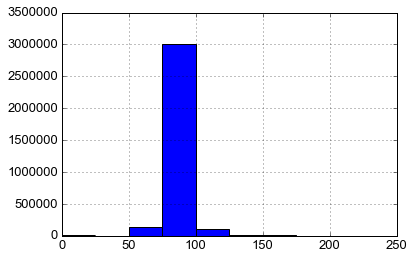

In [24]:
df[df.DY == 1].mll.hist( range=(0, 250))

In [25]:
s = {}
for key in scales.keys():
    s[key] = scales[key] * testing_scales[key]

In [ ]:
df_data = rp.read_root("pan_data_Sept.root")

In [ ]:
df_data.head()

In [ ]:
data_bins = bin_df( df_data[df_data.mll > 50. ], "mll", scales={"Da": 1}, range=(50, 250))

In [ ]:
x_data = []
for iter, ele in enumerate(data_bins["Da"][1]):
    if iter+1 < data_bins["Da"][1].shape[0]: 
        x = ( data_bins["Da"][1][iter+1] - ele ) / 2 + ele
        x_data.append( x )
print x_data

In [ ]:

plt.errorbar( x_data, data_bins["Da"][0], yerr=np.sqrt(data_bins["Da"][0]), color="black")

In [ ]:
def plot_hist( bins, processes=[ "WW", "TT", "WZ", "ZZ", "DY"], x_range=None, y_range=None, title=None, y_label=None, color=colors, logy=True, x_minor_ticks=True):
    """
    Histogramming stuffs
    plot_hist( bins, processes=[ "WW", "TT", "WZ", "ZZ", "DY"], x_range=None, y_range=None, title=None, y_label=None, color=colors, logy=True, x_minor_ticks=True)
    """
    fig, ax = plt.subplots(figsize=(16, 9))

    rect = []
    sum_bins = np.zeros(len(bins[processes[0]][0]))
    for process in processes:

        bottom = sum_bins
        rect.append(ax.bar( bins[process][1][:-1], bins[process][0],
                          bins[process][1][1]-bins[process][1][0] , color = colors[process],
                          edgecolor = colors[process], bottom=bottom ))
        sum_bins +=bins[process][0]


    #Configurables
    ax.set_yscale("log", nonposy='clip')
    if x_range!=None:ax.set_xlim(x_range)
    if y_range==None:ax.set_ylim( bottom=1,  top= sum_bins.max()*30.)

    if y_label != None:
        plt.ylabel(y_label, position=(-0.25, 1.), va='top', ha='right', fontsize=18, fontname='Arial')
    if title != None:
        plt.xlabel( title, position=(1., 0.), va='bottom', ha='right', fontsize=18, fontname='Arial')

    ###################################
    #Increase major tick label sizes
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
    ###################################
    # alter tick lengths
    ax.yaxis.set_tick_params(length=10)
    ax.yaxis.set_tick_params(which='minor',length=5)
    ax.xaxis.set_tick_params(length=10)
    ax.xaxis.set_tick_params(which='minor',length=5)


    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 20

    return rect, processes



In [ ]:
plot_hist( stuff, processes=["WW", "TT", "DY"] )
plt.errorbar( x_data, data_bins["Da"][0], yerr=np.sqrt(data_bins["Da"][0]), color="black", ecolor="black", label="asdf", fmt="o")
plt.legend(frameon=False)

In [ ]:
plt.errorbar?

In [ ]:
stuff = bin_df(df[df.mll > 50], "mll", range=(50,250), scales=scales) 

(<matplotlib.figure.Figure at 0x12d1f3c50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12bbcd910>)

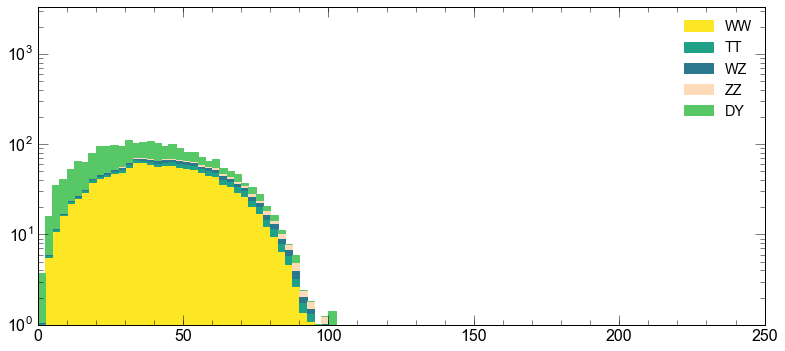

In [42]:
plot_hist( bin_df(test_df[(test_df.mll > 50) & (test_df.pred_WW > cut)], "qT", scales=s, range=(0, 250)) )

(<matplotlib.figure.Figure at 0x126196610>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12458a090>)

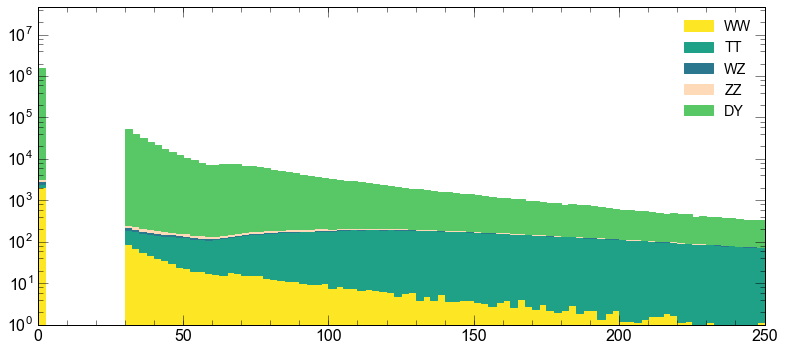

In [42]:
plot_hist( bin_df(test_df[(test_df.mll > 50)], "HT", scales=s, range=(0, 250)) )

In [14]:
plot_hist( bin_df(test_df[(test_df.mll > 50) & (test_df.pred_WW > cut)], "qT", scales=s, range=(0, 250)) )

AttributeError: 'DataFrame' object has no attribute 'pred_WW'

In [1]:
plot_hist( bin_df(df[(df.mll > 50) ], "MET_Phi", range=(0, 250)) )

NameError: name 'plot_hist' is not defined

(<matplotlib.figure.Figure at 0x129998950>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1299c9510>)

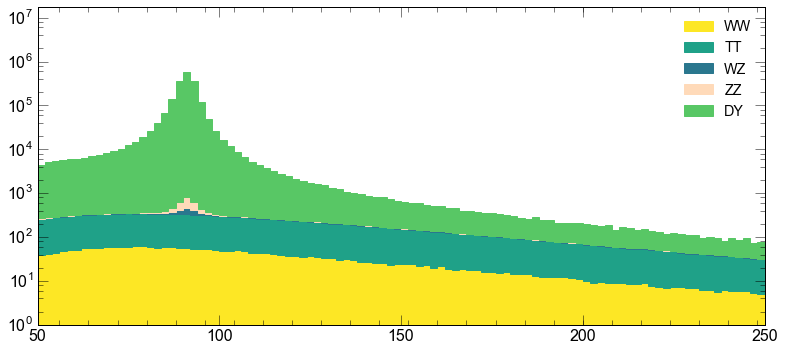

In [40]:
plot_hist( bin_df(df[(df.mll > 50)], "mll", range=(50, 250)) )

(<matplotlib.figure.Figure at 0x1174f0e90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11693bd50>)

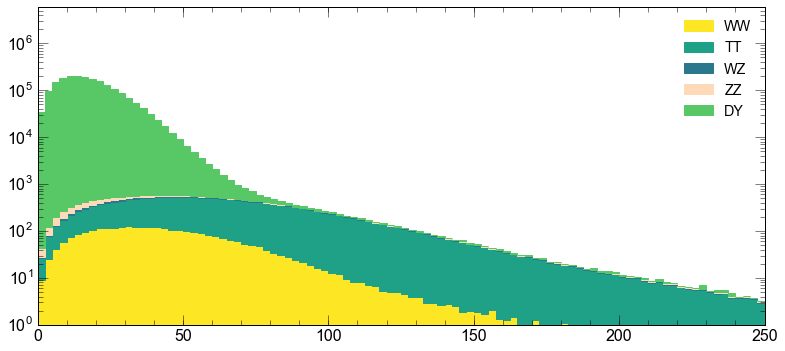

In [81]:
plot_hist( bin_df(df[(df.mll > 50) ], "metMod", range=(0, 250)) )

(<matplotlib.figure.Figure at 0x140d0bc90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13bbb96d0>)

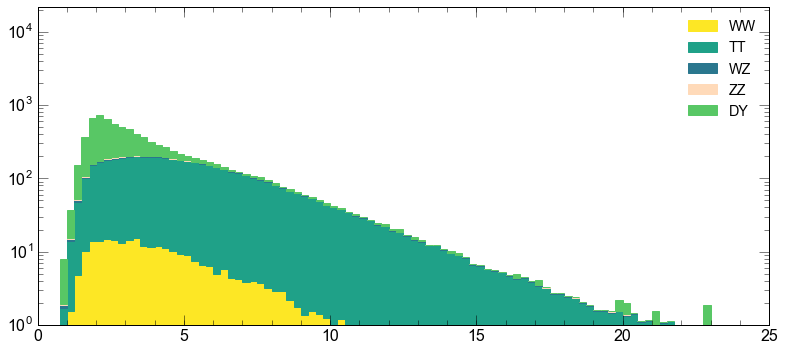

In [96]:
plot_hist( bin_df(df[(df.mll > 50) & ((df.mll > 105) | (df.mll < 75)) & (df.lep2_pt > 45) & (df.metMod > 20) & (df.numb_jets > 0)], "metDIVET", range=(0, 25)) )

(<matplotlib.figure.Figure at 0x12f85a550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12fb8d790>)

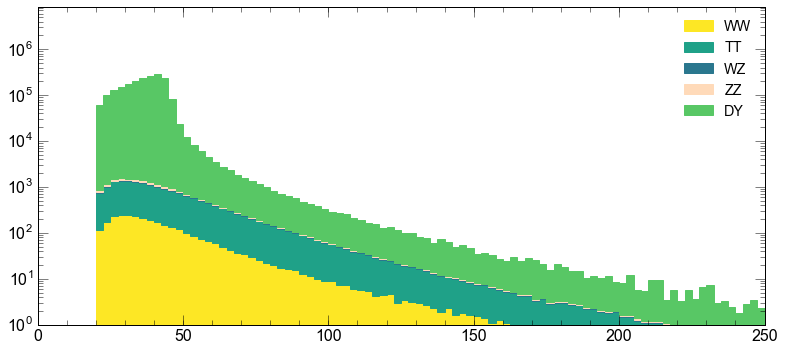

In [88]:
plot_hist( bin_df(df[(df.mll > 50) ], "lep2_pt", range=(0, 250)) )

(<matplotlib.figure.Figure at 0x110992a10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12590a990>)

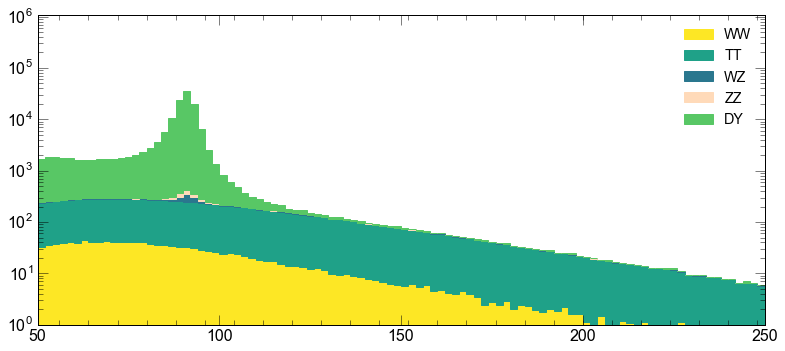

In [65]:
plot_hist( bin_df(df[(df.mll > 50) & (df.metDIVET > .4)], "mll", range=(50, 250)) )

In [91]:
df["metDIVET"] = df.metMod / np.sqrt(df.mll + 1)

In [37]:
df[ (df.metDIVET > .4) & (df.DY == 1) ].shape[0] * scales["DY"]

531351.5613480195

In [68]:
print df[ (df.metDIVET > .4) & (df.WW == 1) & ((df.mll > 105) | (df.mll < 75))].shape[0] * scales["WW"]
print df[ (df.metDIVET > .4) & (df.DY == 1) & ((df.mll > 105) | (df.mll < 75))].shape[0] * scales["DY"]
df[ (df.metDIVET > .4) & (df.TT == 1) & ((df.mll > 105) | (df.mll < 75))].shape[0] * scales["TT"]

4535.29366884
75223.5157636


35266.62623777956

In [47]:
clf.feature_importances_

array([  2.20735228e-01,   3.91340197e-02,   2.29630460e-02,
         1.62518651e-02,   5.83029131e-02,   6.28935166e-02,
         9.82916571e-02,   9.52935051e-02,   2.25945541e-02,
         8.41998495e-02,   1.37022486e-01,   5.01787694e-04,
         6.99536309e-02,   3.98097962e-02,   2.64242523e-02,
         4.72603970e-03,   8.67912839e-04,   3.07746896e-05,
         3.16536694e-06])

In [48]:
features

['nBJet',
 'numb_jets',
 'lep1_pt',
 'lep2_pt',
 'METProj',
 'qT',
 'mll',
 'metMod',
 'dPhiLLMET',
 'HT',
 'lep_Type',
 'numbExtraLep',
 'mllMET',
 'jetPt1',
 'jetPt2',
 'jetPt3',
 'jetPt4',
 'jetPt5',
 'jetPt6']

In [49]:
f = {}
for iter, i in enumerate(features):
    f[i] = clf.feature_importances_[iter]
print f

{'METProj': 0.058302913079655419, 'mllMET': 0.069953630940226497, 'qT': 0.062893516612915021, 'nBJet': 0.22073522845933322, 'dPhiLLMET': 0.022594554082241491, 'jetPt5': 3.0774689643886696e-05, 'jetPt1': 0.039809796182747104, 'lep2_pt': 0.016251865057051694, 'mll': 0.098291657061822815, 'jetPt2': 0.026424252262018378, 'metMod': 0.095293505057085864, 'numbExtraLep': 0.00050178769385153543, 'HT': 0.084199849512851546, 'jetPt6': 3.1653669439483328e-06, 'jetPt4': 0.00086791283854740348, 'numb_jets': 0.039134019746328283, 'lep1_pt': 0.022963046020170338, 'lep_Type': 0.13702248564123021, 'jetPt3': 0.0047260396953353462}


In [50]:
f_ = {'METProj': 0.064878221823268772, 'jetPt6': 6.6200854869756748e-06, 'qT': 0.092343212144567921, 'nBJet': 0.17810713864543012, 'dPhiLLMET': 0.063858276550805601, 'jetPt5': 3.2160560492117525e-05, 'jetPt1': 0.038101006131645777, 'lep2_pt': 0.028776965160000386, 'mll': 0.13780490185672728, 'jetPt2': 0.031335497624313181, 'metMod': 0.081532951417751215, 'HT': 0.049539720595083055, 'jetPt4': 0.00099894793542223146, 'numb_jets': 0.041636796481798584, 'lep1_pt': 0.021577049342251228, 'lep_Type': 0.16138964190224908, 'jetPt3': 0.0080808917427064968}

In [52]:
for k in f_.keys():
    print k, f_[k] - f[k]

 METProj 0.00657530874361
lep1_pt -0.00138599667792
qT 0.0294496955317
nBJet -0.0426280898139
jetPt4 0.000131035096875
jetPt6 3.45471854303e-06
jetPt1 -0.0017087900511
lep2_pt 0.0125251001029
mll 0.0395132447949
jetPt2 0.00491124536229
jetPt5 1.38587084823e-06
HT -0.0346601289178
numb_jets 0.00250277673547
metMod -0.0137605536393
dPhiLLMET 0.0412637224686
lep_Type 0.024367156261
jetPt3 0.00335485204737


In [36]:
s

{'DY': 3.3588385491246258,
 'TT': 0.062169485504297954,
 'WJ': 1,
 'WW': 0.17305141203712404,
 'WZ': 0.010286529245348936,
 'ZZ': 0.017875882100117674}

In [37]:
scales

{'DY': 2.249507050345541,
 'TT': 0.04168646725435144,
 'WJ': 1,
 'WW': 0.11600700009829576,
 'WZ': 0.010286529245348936,
 'ZZ': 0.017875882100117674}

In [38]:
testing_scales

{'DY': 1.4931442640327282,
 'TT': 1.4913589373013707,
 'WJ': 1,
 'WW': 1.49173249795696,
 'WZ': 1,
 'ZZ': 1}

In [27]:
test_df.shape[0]

5527272

In [30]:
range(1,2)

[1]

In [62]:
f = {}
for iter, i in enumerate(features):
    f[i] = clf.feature_importances_[iter]
print f

{'METProj': 0.072322819986879339, 'qT': 0.056317522236765477, 'nBJet': 0.20709971081440093, 'dPhiLLMET': 0.021633607208930438, 'jetPt1': 0.030889157579597634, 'lep2_pt': 0.023705580472715725, 'mll': 0.10496611329227018, 'jetPt2': 0.060274350881734211, 'metDIVET': 0.041366138272305536, 'metMod': 0.1103292942128586, 'numbExtraLep': 0.00062639811687104725, 'HT': 0.061162095987932631, 'numb_jets': 0.033070774760643691, 'lep1_pt': 0.021567961707390376, 'lep_Type': 0.15466847446870405}
